In [1]:
# This notebook uses Long Short-Term Memory (LSTM) to predict the closing stock price of a corporation using the past 60 day stock price.

# Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
plt.style.use('fivethirtyeight')

# Get cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/victoru/anaconda3/envs/testpython/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get the past year stock price
# today's date
today = pd.to_datetime('today').strftime('%Y-%m-%d')
# 5 year ago
start = pd.to_datetime('today') - pd.DateOffset(years=5)
df = web.DataReader('AAPL', data_source='yahoo', start=start, end=today)

In [3]:
# Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataarray = data.values

training_data_len = math.ceil( len(dataarray) * .8 )

In [4]:
# define dataloading method
def dataloading(data, seq_len = 60, training_data_len = len(data)*.8):
    sc = MinMaxScaler(feature_range=(0, 1))
    scaled_data = sc.fit_transform(data)

    x = []
    y = []
    for i in range(len(scaled_data)-seq_len-1):
        _x = scaled_data[i:(i+seq_len)]

        _y = scaled_data[i+seq_len]
        x.append(_x)

        y.append(_y)

    # Get the number of rows to train the model on
    
    test_data_len = len(dataarray) - training_data_len

    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    trainX = Variable(torch.Tensor(np.array(x[0:training_data_len])))
    trainY = Variable(torch.Tensor(np.array(y[0:training_data_len])))

    testX = dataX[training_data_len:]
    testY = dataY[training_data_len:]

    return trainX, trainY, testX, testY, dataX, dataY, sc


In [5]:
# load data
trainX, trainY, testX, testY, dataX, dataY, sc = dataloading(dataarray, training_data_len=training_data_len)

# move data to device
trainX = trainX.to(device)
trainY = trainY.to(device)
testX = testX.to(device)
testY = testY.to(device)
dataX = dataX.to(device)
dataY = dataY.to(device)


In [6]:
# Build the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, num_classes=1):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [7]:
# define training method
def train(model, trainX, trainY, num_epochs=100, learning_rate=0.001):

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(trainX)
        loss = criterion(outputs, trainY)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 10 == 0:
            print ('Epoch [{}/{}], Loss: {:.4f}' 
                .format(epoch+1, num_epochs, loss.item()))
    
    return model
       

In [8]:
# train the model
model = LSTM()
model = train(model.to(device), trainX, trainY, num_epochs=100, learning_rate=0.001)


Epoch [10/100], Loss: 0.0943
Epoch [20/100], Loss: 0.0534
Epoch [30/100], Loss: 0.0436
Epoch [40/100], Loss: 0.0268
Epoch [50/100], Loss: 0.0092
Epoch [60/100], Loss: 0.0060
Epoch [70/100], Loss: 0.0034
Epoch [80/100], Loss: 0.0024
Epoch [90/100], Loss: 0.0017
Epoch [100/100], Loss: 0.0013


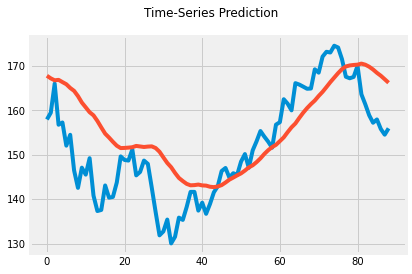

In [9]:
# Test the model
model.eval()
with torch.no_grad():
    train_predict = model(dataX)
    data_predict = train_predict.cpu().data.numpy()
    dataY_plot = dataY.cpu().data.numpy()

    # Invert predictions
    data_predict = sc.inverse_transform(data_predict)
    dataY_plot = sc.inverse_transform(dataY_plot)
    
    #plt.axvline(x=training_data_len, c='r', linestyle='--')

    plt.plot(dataY_plot[-100:-1])
    plt.plot(data_predict[-100:-1])
    plt.suptitle('Time-Series Prediction')
    plt.show()

In [10]:
print(data_predict[-10:-1])
print(dataY_plot[-10:-1])


[[170.29108]
 [170.52939]
 [170.28404]
 [169.83162]
 [169.20486]
 [168.45306]
 [167.79979]
 [167.01678]
 [166.22379]]
[[170.03   ]
 [163.62   ]
 [161.38   ]
 [158.90999]
 [157.22   ]
 [157.95999]
 [155.81   ]
 [154.52998]
 [155.96   ]]
